In [3]:
path = "/home/piotr/projects/twitter"
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import gc
import json
import pickle
import datetime
import random
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import itertools
from functools import partial
import os
import ast
import pdb
import sys
sys.path.append(os.path.join(path, 'src'))
from twitter_models.polarization import ModelPolarization
from twitter_tools.utils import read_files, clean_tweets, filter_data
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from linearmodels import RandomEffects

In [4]:
gov = pickle.load(open(os.path.join(path, 'data/sample/gov_sample.pickle'),"rb"))
opp = pickle.load(open(os.path.join(path, 'data/sample/opp_sample.pickle'),"rb"))
parties = {k:"gov" for k in gov}
parties.update({k:"opp" for k in opp})
path_data = os.path.join(path, "data/clean")
vocab = json.load(open("topic_vocab.json","r"))
nonpolish_ids = json.load(open(os.path.join(path_data, "non_polish_ids.json"), "r"))
path_stopwords = "/home/piotr/nlp/polish.stopwords.txt"
stopwords = []
with open(path_stopwords, "r") as f:
    for word in f:
        if word != "nie":
            stopwords.append(word.strip("\n"))

#Get random assignment
random_keys = list(parties.keys()); random.shuffle(random_keys) #randomize keys
random_values = list(parties.values()); random.shuffle(random_values) #randomize values
randomized = dict(zip(random_keys, random_values)) #zip into dict

In [5]:
def data_filter(data, n):
    data.loc[:,("lemmatized")] = data.loc[:,("lemmatized")].apply(lambda x: x.split()) #strsplit
    data = data[data.lemmatized.apply(lambda x: len(x) >= n)] #longer than n
    data.loc[:,("lemmatized")] = data.loc[:,("lemmatized")].apply(lambda x: [word for word in x if word not in stopwords]) #remove stopwords
    data.loc[:,("lemmatized")] = data.loc[:,("lemmatized")].apply(lambda x: " ".join(x)) #str join
    data[data["user-id_str"].apply(lambda x: x not in nonpolish_ids)] #exclude non-polish users
    data = data.loc[data.polish.astype(float) > 0.5] #more than 50% polish words
    return data[["lemmatized", "tokenized", "day", "id_str", "source", "user-id_str", "retweet"]]

The call below writes a new file that contains data from the day-level files filtered using the data filtering function defined above:

In [6]:
filter_data(path_data, os.path.join(path_data, "twitter_data.csv"), 84, filter_fun = partial(data_filter, n = 5))

84it [11:43,  8.38s/it]


*The leave-out estimator of partisanship is obtained using the following process. Each user's speech-generating process is assumed to follow a multinomial distribution over the possible phrase set, where each phrase is picked with a certain choice probability. The*


\begin{equation}
\hat{\pi}_{t}^{LO} = \frac{1}{2} \frac{1}{|R_{t}|} \sum_{i \in R_{t}} \hat{q}_{i,t}  \cdot \hat{p}_{-i,t} +  \frac{1}{2} \frac{1}{|D_{t}|} \sum_{i \in D_{t}} \hat{q}_{i,t}  \cdot (1 - \hat{p}_{-i,t})\\
\end{equation}


$\hat{p}_{-i,t} = \hat{q}_{-i,t}^{R} / (\hat{q}_{-i,t}^{R} + \hat{q}_{-,it}^{D})$ is the probability of an observer with a neutral prior assigning a speaker to government based only on a given phrase



$\hat{q}_{i,t} = c_{i,t} / m_{i,t}$ are the phrase frequencies for speaker $i$ at time $t$ 




*The estimation of confidence interval for the leave-out estimator is obtained via sub-sampling, using the procedure described by Gentzkow et al. (2019), based on Politis et al. (1990) procedure. Specifically:*

(THE CI FORMULA GOES HERE)

## 1. The leave-out estimator of partisanship
- excluding retweets
- minimum lenght of tweet - 5 (lemmatized, including stopwords)
- maximum minimum number of bigram occurence in one day - 5

In [7]:
if os.path.isfile(os.path.join(path, "results/polarization/polarization_no_retweets.p")):
    results = pickle.load(open(os.path.join(path, "results/polarization/polarization_no_retweets.p"),"rb"))
else:
    results = defaultdict(lambda: dict().fromkeys(["true","random","disaggregated"])) #store for each day
    twitter_data = pd.read_csv(os.path.join(path_data, "twitter_data.csv"), index_col = 0).reset_index(drop = True)
    for day, data in tqdm(twitter_data.groupby("day")):
        data = data[np.logical_not(data.retweet.apply(ast.literal_eval))] #drop retweets
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"] #get tweets
        model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
        results[day]["true"] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
        results[day]["disaggregated"] = model.estimate(parties, users, tweets, 
                                                               level = "speaker")

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
        results[day]["random"] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
    results = dict(results) #convert defaultdict to dict
    pickle.dump(results, open(os.path.join(path, "results/polarization/polarization_no_retweets.p"),"wb"))

### Aggregated analysis:

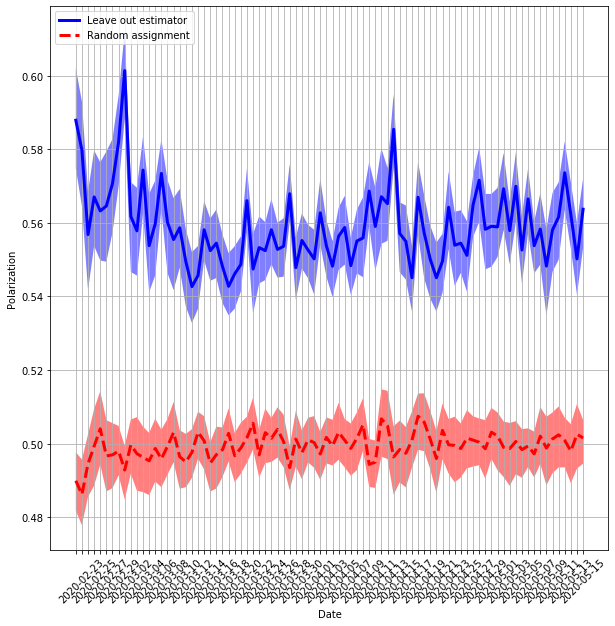

In [5]:
aggregated = {day:{k + "_" + k1:v1 for k, v in res.items() if k != "disaggregated" for k1, v1 in v.items()} for day, res in results.items()}
aggregated = pd.DataFrame(aggregated).T.reset_index()
fig, ax = plt.subplots(1,figsize = (10,10))
date = np.array(list(results.keys()))
ax.plot(date, aggregated["true_estimate"], lw = 3, label='Leave out estimator', color='blue')
ax.plot(date, aggregated["random_estimate"], lw = 3, linestyle = "--", label='Random assignment', color='red')
ax.fill_between(date, aggregated["true_upper_ci"], aggregated["true_lower_ci"], facecolor='blue', alpha=0.5)
ax.fill_between(date, aggregated["random_upper_ci"], aggregated["random_lower_ci"], facecolor='red', alpha=0.5)
ax.legend(loc='upper left')
ax.xaxis.set_tick_params(rotation=45)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Polarization')
ax.grid()
plt.show()

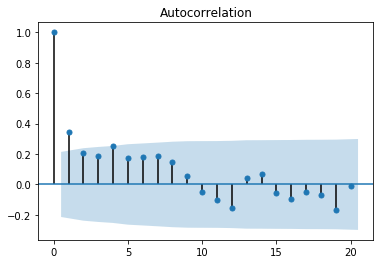

In [6]:
plot_acf(aggregated["true_estimate"])
plt.show()

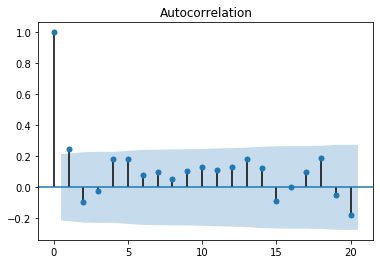

In [7]:
plot_acf(aggregated["random_estimate"])
plt.show()

### Disaggregated analysis:

In [27]:
def get_opposites(data, cols):
    for col in cols:
        gov_col = col + '_gov'
        opp_col = col + '_opp'
        data[col + '_own'] = np.where(data['source'] == 'gov', data[gov_col], data[opp_col])
        data[col + '_other'] = np.where(data['source'] == 'gov', data[opp_col], data[gov_col])
    return data

In [42]:
#load connections data (retweets, replies, etc)
connections = pickle.load(open(os.path.join(path, "data/connections.p"), "rb"))
connections = pd.DataFrame(connections)
connections.index.names = ['day', 'user-id_str']
connections.reset_index(inplace = True)
connections['source'] = np.where(connections['user-id_str'].isin(gov), 'gov', 'opp')
cols = [col for col in connections.columns if 'gov' in col or 'opp' in col]
connections[cols] = connections[cols].apply(lambda x: x/connections.total)


scores = pd.DataFrame()
for k, v in results.items():
    tmp = pd.DataFrame(v['disaggregated']).T
    tmp["day"] = k
    scores = scores.append(tmp)
scores.columns = ["score", "user-id_str","day"]

scores = pd.merge(connections, scores) #merge with rt information

In [43]:
scores = get_opposites(scores, ['in_reply_to_user_id_str', 
                                'retweeted_status-in_reply_to_user_id_str', 
                                'retweeted_status-user-id_str',
                                'quoted_status-in_reply_to_user_id_str', 
                                'quoted_status-user-id_str', 'sum', 
                                'retweeted_status-quoted_status-in_reply_to_user_id_str', 
                                'retweeted_status-quoted_status-user-id_str'])

In [41]:
scores["date_num"] = pd.to_datetime(scores["day"], format = "%Y-%m-%d").astype(int) #numeric index for date
scores = scores.set_index(["user-id_str","date_num"]) #set index for panel models
scores = scores.dropna() #drop missing
scores = sm.add_constant(scores) #constant
scores[col for col in scores.columns if 'own' in col or 'other' in col].apply(lambda x: x.shift(-1))
scores['score_lag'] = scores['score'].shift(-1)

KeyError: "None of ['user-id_str'] are in the columns"

In [40]:
ref = RandomEffects(scores.score.astype(float), scores[['const','retweeted-status-user-id_str_other_lag','retweeted-status-user-id_str_own_lag']])
res = ref.fit(cov_type='clustered', cluster_entity=True)
print(res)

KeyError: "['retweeted-status-user-id_str_other_lag', 'retweeted-status-user-id_str_own_lag'] not in index"

## 2. Leave-out estimator only for tweets longer than 10 words

In [37]:
if os.path.isfile("results/polarization/polarization_no_retweets_10.p"):
    results = pickle.load(open("results/polarization/polarization_no_retweets_10.p","rb"))
else:
    results = defaultdict(lambda: dict().fromkeys(["true","random","disaggregated"])) #store for each day
    N = 84 #number of days to estimate
    for data in tqdm(read_files(path, N, filter_fun = partial(keep_n, n = 10))):
        parties = data["source"].astype(str).tolist() #get parties list
        users = data["user-id_str"].astype(str).tolist() #get users list
        tweets = data["preprocessed"].tolist()
        model = ModelPolarization(parties, users, tweets)
        results[data.day.unique()[0]]["true"] = model.estimate(conf_int = 100)
        results[data.day.unique()[0]]["disaggregated"] = model.estimate(conf_int = 100, 
                                                                              disaggregated = True, 
                                                                              absolute = False)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(random_parties, users, tweets)
        results[data.day.unique()[0]]["random"] = model.estimate(conf_int = 100)
    results = dict(results) #convert defaultdict to dict
    pickle.dump(results, open("results/polarization/polarization_no_retweets_10.p","wb"))

### Aggregated analysis:

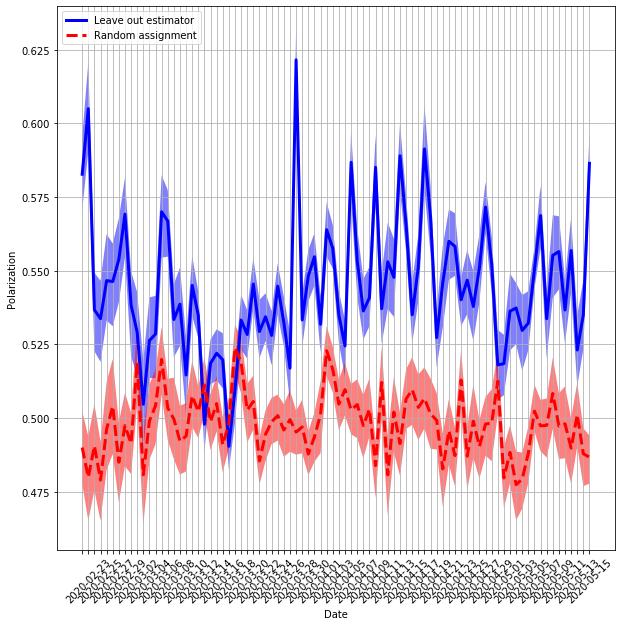

In [38]:
aggregated = {day:{k + "_" + k1:v1 for k, v in res.items() if k != "disaggregated" for k1, v1 in v.items()} for day, res in results.items()}
aggregated = pd.DataFrame(aggregated).T.reset_index()
fig, ax = plt.subplots(1,figsize = (10,10))
date = np.array(list(results.keys()))
ax.plot(date, aggregated["true_estimate"], lw = 3, label='Leave out estimator', color='blue')
ax.plot(date, aggregated["random_estimate"], lw = 3, linestyle = "--", label='Random assignment', color='red')
ax.fill_between(date, aggregated["true_upper_ci"], aggregated["true_lower_ci"], facecolor='blue', alpha=0.5)
ax.fill_between(date, aggregated["random_upper_ci"], aggregated["random_lower_ci"], facecolor='red', alpha=0.5)
ax.legend(loc='upper left')
ax.xaxis.set_tick_params(rotation=45)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Polarization')
ax.grid()
plt.show()

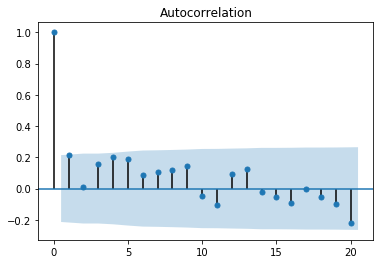

In [42]:
plot_acf(aggregated["true_estimate"])
plt.show()

### Disaggregated analysis:

In [39]:
stats = pd.read_csv("../overview.csv", dtype= str, index_col = 0)
scores = pd.DataFrame()
for k, v in results.items():
    tmp = pd.DataFrame(v["disaggregated"])
    tmp["day"] = k
    scores = scores.append(tmp)
scores.columns = ["score", "user-id_str","day"]
scores = pd.merge(stats, scores) #merge with rt information
scores["date_num"] = pd.to_datetime(scores["day"], format = "%Y-%m-%d").astype(int) #numeric index for date
scores = scores.set_index(["user-id_str","date_num"]) #set index for panel models
scores = scores.dropna() #drop missing
scores = sm.add_constant(scores) #constant
scores["value_lag"] = scores.score.groupby("user-id_str").shift(-1)
scores["gov_retweet_lag"] = scores.gov_retweet.groupby("user-id_str").shift(-1)
scores["opp_retweet_lag"] = scores.opp_retweet.groupby("user-id_str").shift(-1)

In [40]:
ref = RandomEffects(scores.score.astype(float), scores[["const","gov_retweet","opp_retweet","value_lag"]].astype(float))
res = ref.fit(cov_type='clustered', cluster_entity=True)
print(res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  score   R-squared:                        0.1688
Estimator:              RandomEffects   R-squared (Between):              0.0628
No. Observations:              115352   R-squared (Within):              -0.0029
Date:                Fri, Jun 12 2020   R-squared (Overall):              0.0238
Time:                        13:19:35   Log-likelihood                 5.359e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7809.1
Entities:                        5681   P-value                           0.0000
Avg Obs:                       20.305   Distribution:                F(3,115348)
Min Obs:                       1.0000                                           
Max Obs:                       83.000   F-statistic (robust):             97.764
                            

## 3. Leave-out estimator only for data with words similar to *wirus*

In [11]:
def keep_words(data, words):
    words = set(words)
    data = data.loc[data.preprocessed.apply(lambda x: len(set(ast.literal_eval(x)).intersection(words))) > 0]
    return data
keep_korona = partial(keep_words, words = vocab["wirus"]) #filter function to only keep words related to wirus

In [16]:
if os.path.isfile("results/polarization/polarization_no_retweets_wirus.p"):
    results = pickle.load(open("results/polarization/polarization_no_retweets_wirus.p","rb"))
else:

    results = defaultdict(lambda: dict().fromkeys(["true","random","disaggregated"])) #store for each day
    for data in tqdm(read_files(path, 84, filter_fun = keep_korona)):
        data = data.loc[np.logical_not(data.english | data.retweet)] #drop English
        data["preprocessed"] = data["preprocessed"].apply(lambda x: " ".join(ast.literal_eval(x)).lower()).tolist()
        parties = data["source"].astype(str).tolist() #get parties list
        users = data["user-id_str"].astype(str).tolist() #get users list
        tweets = data["preprocessed"].tolist()
        model = ModelPolarization(parties, users, tweets)
        results[data.day.unique()[0]]["true"] = model.estimate(conf_int = 100)
        results[data.day.unique()[0]]["disaggregated"] = model.estimate(conf_int = 100, 
                                                                              disaggregated = True, 
                                                                              absolute = False)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(random_parties, users, tweets)
        results[data.day.unique()[0]]["random"] = model.estimate(conf_int = 100)
    results = dict(results)
    pickle.dump(results, open("results/polarization/polarization_no_retweets_wirus.p","wb"))

### Aggregated analysis:

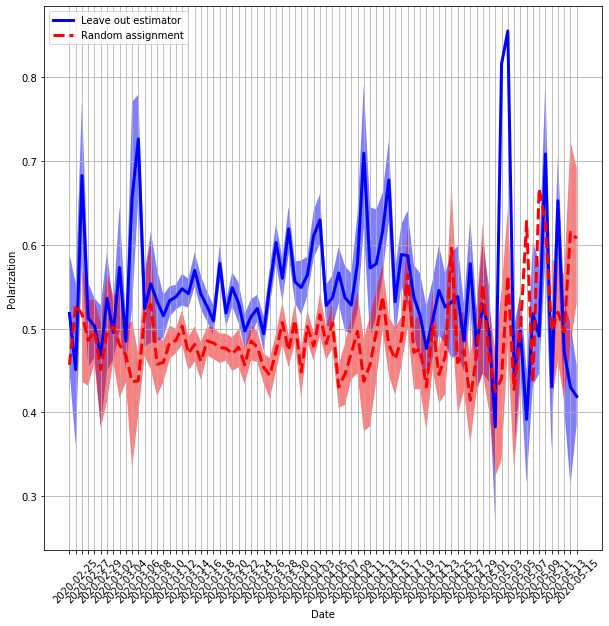

In [17]:
aggregated = {day:{k + "_" + k1:v1 for k, v in res.items() if k != "disaggregated" for k1, v1 in v.items()} for day, res in results.items()}
aggregated = pd.DataFrame(aggregated).T.reset_index()
fig, ax = plt.subplots(1,figsize = (10,10))
date = np.array(list(results.keys()))
ax.plot(date[2:], aggregated["true_estimate"][2:], lw = 3, label='Leave out estimator', color='blue')
ax.plot(date[2:], aggregated["random_estimate"][2:], lw = 3, linestyle = "--", label='Random assignment', color='red')
ax.fill_between(date[2:], aggregated["true_upper_ci"][2:], aggregated["true_lower_ci"][2:], facecolor='blue', alpha=0.5)
ax.fill_between(date[2:], aggregated["random_upper_ci"][2:], aggregated["random_lower_ci"][2:], facecolor='red', alpha=0.5)
ax.legend(loc='upper left')
ax.xaxis.set_tick_params(rotation=45)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Polarization')
ax.grid()
plt.show()

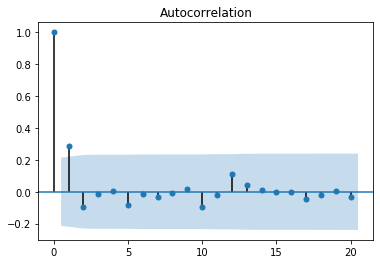

In [21]:
plot_acf(aggregated["true_estimate"])
plt.show()

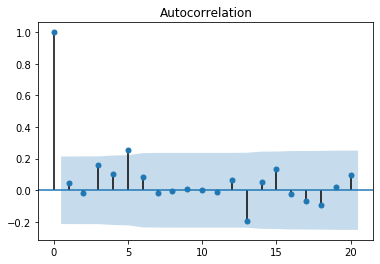

In [22]:
plot_acf(aggregated["random_estimate"])
plt.show()

## Disaggregated data:

In [18]:
stats = pd.read_csv("../overview.csv", dtype= str, index_col = 0)
scores = pd.DataFrame()
for k, v in results.items():
    tmp = pd.DataFrame(v["disaggregated"])
    tmp["day"] = k
    scores = scores.append(tmp)
scores.columns = ["score", "user-id_str","day"]
scores = pd.merge(stats, scores) #merge with rt information
scores["date_num"] = pd.to_datetime(scores["day"], format = "%Y-%m-%d").astype(int) #numeric index for date
scores = scores.set_index(["user-id_str","date_num"]) #set index for panel models
scores = scores.dropna() #drop missing
scores = sm.add_constant(scores) #constant
scores["value_lag"] = scores.score.groupby("user-id_str").shift(-1)
scores["gov_retweet_lag"] = scores.gov_retweet.groupby("user-id_str").shift(-1)
scores["opp_retweet_lag"] = scores.opp_retweet.groupby("user-id_str").shift(-1)

In [19]:
ref = RandomEffects(scores.score.astype(float), scores[["const","gov_retweet","opp_retweet","value_lag"]].astype(float))
res = ref.fit(cov_type='clustered', cluster_entity=True)
print(res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  score   R-squared:                        0.0989
Estimator:              RandomEffects   R-squared (Between):              0.0637
No. Observations:               18405   R-squared (Within):              -0.0125
Date:                Fri, Jun 12 2020   R-squared (Overall):              0.0146
Time:                        12:22:22   Log-likelihood                    6449.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      673.47
Entities:                        2593   P-value                           0.0000
Avg Obs:                       7.0980   Distribution:                 F(3,18401)
Min Obs:                       1.0000                                           
Max Obs:                       74.000   F-statistic (robust):             26.530
                            

## 4. Leave-out estimator only for data with words similar to *wybory*

In [27]:
keep_wybory = partial(keep_words, words = vocab["wybory"]) #filter function to only keep words related to wybory

In [27]:
if os.path.isfile("results/polarization/polarization_no_retweets_wybory.p"):
    results = pickle.load(open("results/polarization/polarization_no_retweets_wybory.p","rb"))
else:

    results = defaultdict(lambda: dict().fromkeys(["true","random","disaggregated"])) #store for each day
    for data in tqdm(read_files(path, 84, filter_fun = keep_wybory)):
        data = data.loc[np.logical_not(data.english | data.retweet)] #drop English
        data["preprocessed"] = data["preprocessed"].apply(lambda x: " ".join(ast.literal_eval(x)).lower()).tolist()
        parties = data["source"].astype(str).tolist() #get parties list
        users = data["user-id_str"].astype(str).tolist() #get users list
        tweets = data["preprocessed"].tolist()
        model = ModelPolarization(parties, users, tweets)
        results[data.day.unique()[0]]["true"] = model.estimate(conf_int = 100)
        results[data.day.unique()[0]]["disaggregated"] = model.estimate(conf_int = 100, 
                                                                              disaggregated = True, 
                                                                              absolute = False)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(random_parties, users, tweets)
        results[data.day.unique()[0]]["random"] = model.estimate(conf_int = 100)
    results = dict(results)
    pickle.dump(results, open("results/polarization/polarization_no_retweets_wybory.p","wb"))

### Aggregated analysis:

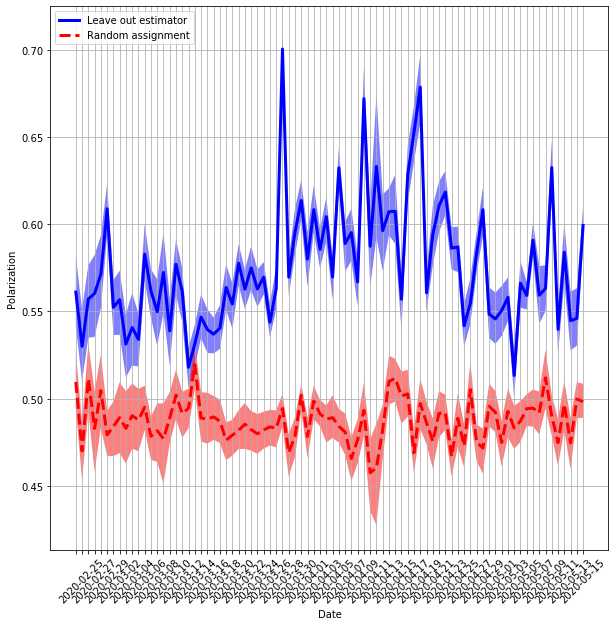

In [28]:
aggregated = {day:{k + "_" + k1:v1 for k, v in res.items() if k != "disaggregated" for k1, v1 in v.items()} for day, res in results.items()}
aggregated = pd.DataFrame(aggregated).T.reset_index()
fig, ax = plt.subplots(1,figsize = (10,10))
date = np.array(list(results.keys()))
ax.plot(date[2:], aggregated["true_estimate"][2:], lw = 3, label='Leave out estimator', color='blue')
ax.plot(date[2:], aggregated["random_estimate"][2:], lw = 3, linestyle = "--", label='Random assignment', color='red')
ax.fill_between(date[2:], aggregated["true_upper_ci"][2:], aggregated["true_lower_ci"][2:], facecolor='blue', alpha=0.5)
ax.fill_between(date[2:], aggregated["random_upper_ci"][2:], aggregated["random_lower_ci"][2:], facecolor='red', alpha=0.5)
ax.legend(loc='upper left')
ax.xaxis.set_tick_params(rotation=45)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Polarization')
ax.grid()
plt.show()

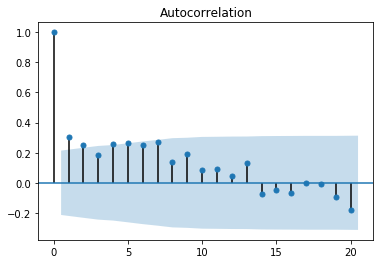

In [29]:
plot_acf(aggregated["true_estimate"])
plt.show()

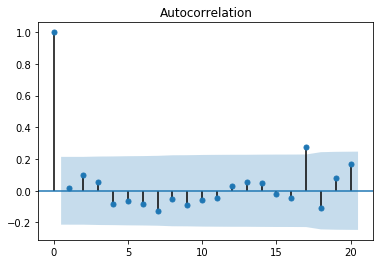

In [30]:
plot_acf(aggregated["random_estimate"])
plt.show()

## Disaggregated data:

In [31]:
stats = pd.read_csv("../overview.csv", dtype= str, index_col = 0)
scores = pd.DataFrame()
for k, v in results.items():
    tmp = pd.DataFrame(v["disaggregated"])
    tmp["day"] = k
    scores = scores.append(tmp)
scores.columns = ["score", "user-id_str","day"]
scores = pd.merge(stats, scores) #merge with rt information
scores["date_num"] = pd.to_datetime(scores["day"], format = "%Y-%m-%d").astype(int) #numeric index for date
scores = scores.set_index(["user-id_str","date_num"]) #set index for panel models
scores = scores.dropna() #drop missing
scores = sm.add_constant(scores) #constant
scores["value_lag"] = scores.score.groupby("user-id_str").shift(-1)
scores["gov_retweet_lag"] = scores.gov_retweet.groupby("user-id_str").shift(-1)
scores["opp_retweet_lag"] = scores.opp_retweet.groupby("user-id_str").shift(-1)

In [33]:
ref = RandomEffects(scores.score.astype(float), scores[["const","gov_retweet","opp_retweet","value_lag"]].astype(float))
res = ref.fit(cov_type='clustered', cluster_entity=True)
print(res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  score   R-squared:                        0.1410
Estimator:              RandomEffects   R-squared (Between):              0.0907
No. Observations:               82488   R-squared (Within):              -0.0054
Date:                Fri, Jun 12 2020   R-squared (Overall):              0.0369
Time:                        12:25:16   Log-likelihood                 2.853e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4514.9
Entities:                        4958   P-value                           0.0000
Avg Obs:                       16.637   Distribution:                 F(3,82484)
Min Obs:                       1.0000                                           
Max Obs:                       83.000   F-statistic (robust):             139.42
                            